In [1]:
import pandas as pd

In [2]:
import cvxpy as cp
import numpy as np
import gurobipy
import pandas as pd
import matplotlib.pyplot as plt
from src.BidSimulator import BidSimulator

# Print the installed solver to see if GUROBI is installed correctly
print("Current installed solvers: ", cp.installed_solvers())

Current installed solvers:  ['CLARABEL', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']


In [3]:
# load day-ahead and real-time prices
DAP = pd.read_csv("./data/CAISO_DAP.csv")
RTP = pd.read_csv("./data/CAISO_RTP.csv")

# read datetime and drop duplicate data
RTP["Date"] = pd.to_datetime(RTP["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP = RTP.drop_duplicates(subset=["Date", "hub"])
DAP["Date"] = pd.to_datetime(DAP["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP = DAP.drop_duplicates(subset=["Date", "zone"])

# pivot data
DAP_pivoted = DAP.pivot(index="Date", columns="zone", values="price")
RTP_pivoted = RTP.pivot(index="Date", columns="hub", values="price")

# rename 'Date' column to 'ts'
DAP_pivoted.index.names = ["ts"]
RTP_pivoted.index.names = ["ts"]

# merge dataframes on index
CAISO_PRICES = pd.merge(DAP_pivoted, RTP_pivoted, on=["ts"], how="outer")
CAISO_PRICES = CAISO_PRICES.ffill().reset_index()

In [4]:
# form datasets
PGAE_NP15 = CAISO_PRICES[["ts", "PGAE", "TH_NP15"]].rename(
    columns={"PGAE": "dap", "TH_NP15": "rtp"}
)
PGAE_ZP26 = CAISO_PRICES[["ts", "PGAE", "TH_ZP26"]].rename(
    columns={"PGAE": "dap", "TH_ZP26": "rtp"}
)
SCE_SP15 = CAISO_PRICES[["ts", "SCE", "TH_SP15"]].rename(
    columns={"SCE": "dap", "TH_SP15": "rtp"}
)
SDGE_SP15 = CAISO_PRICES[["ts", "SDGE", "TH_SP15"]].rename(
    columns={"SDGE": "dap", "TH_SP15": "rtp"}
)

In [85]:
## PARAMETERS

T = 10000         # total timesteps
timestep = 5/60   # 5-minute price intervals 

price = np.array(PGAE_NP15.rtp[:T])  # price of electricity 
# To do: add lookback starting period

eta = 0.8       # roundtrip efficiency
PMax = 2.0      # power rating (MW)
Emax = 8.0      # storage capacity (MWh) 
e0   = .5*Emax  # initial batter state #TO DO: normalize to SoC

## Variables
p = cp.Variable((T), nonneg = True)  # discharge control variable
h = cp.Variable((T), nonneg = True)  # charge control variable
u = cp.Variable((T), boolean = True) # discharge status (binary variable)
v = cp.Variable((T), boolean = True) # charge status (binary variable)
e = cp.Variable((T), nonneg = True)  # battery state

In [83]:
type(np.array(price))

numpy.ndarray

$$\max \pi_\tau = \sum_{t \in \tau}\lambda_t(d_t - c_t)$$
$$0 \leq d_t \leq u_tP_{max}$$
$$0 \leq c_t \leq v_tP_{max}$$
$$ u_t + v_t = 1 $$
$$0 \leq _{t} \leq E_{max}$$
$$e_{t} = e_{t-1} - d_t/\eta + c_t\eta$$ 

In [87]:
obj = cp.Maximize(price@(p-h))

# Initialize an empty constraint set
con_set_1 = []  

# power balance constraint, supply equals demand
# Assume infinite demand: con_set_1.append(g + S*alpha_week + p == LOAD + x) 

# Terminal conditions: con_set_1.append(e[T-1] == Emax/2) # End state at half full 

for t in range(T):  
        con_set_1.append(e[t] <= Emax)  
        con_set_1.append(e[t] >= 0) 
        
        con_set_1.append(p[t] <= u[t]*PMax)  
        con_set_1.append(p[t] >= 0) 

        con_set_1.append(h[t] <= v[t]*PMax)  
        con_set_1.append(h[t] >= 0) 
        
        con_set_1.append(u[t] + v[t] == 1) # enforce discrete charging/discharging states 
        
        if t==0:    
            con_set_1.append(e[0] == eta*h[0]-p[0]/eta + e0)
        else: 
            con_set_1.append(e[t] == eta*h[0]-p[0]/eta + e[t-1])

In [89]:
prob1 = cp.Problem(obj, con_set_1)
prob1.solve(solver = "GUROBI")
prob1.solve();
print("\n Total operating profit: %.1f" % obj.value)


 Total operating profit: 601621.0


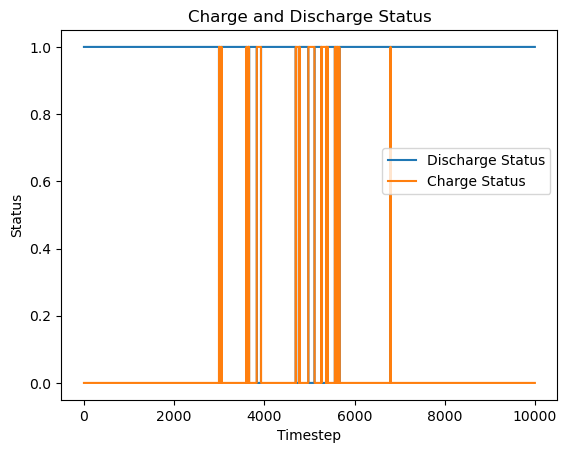

In [90]:
## Plot 3
plt.plot(u.value, label = "Discharge Status")
plt.plot(v.value, label = "Charge Status")
plt.title("Charge and Discharge Status")
plt.xlabel("Timestep")
plt.ylabel('Status')
plt.legend(loc='upper right', bbox_to_anchor=(1, .7))
plt.show()

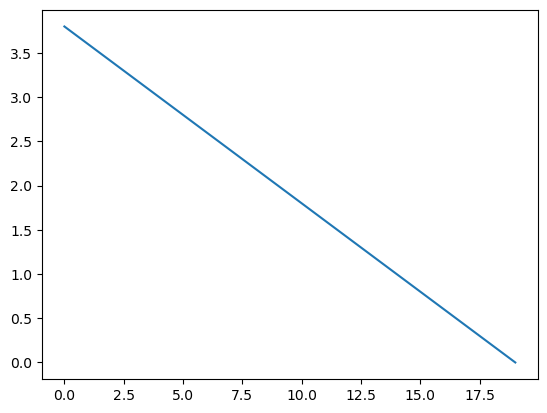

In [36]:
plt.plot(e.value)